<a href="https://colab.research.google.com/github/KendallScott/ML2/blob/main/Scott_Kendall_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 2

This is called DeathToGridSearch because with this example you will never have to think about how to manage a large number of classifiers etc simultaneously.  You will now be able to run and collect results in a very straightforward manner.  #LongLongLiveGridSearch!

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from itertools import product
from sklearn.model_selection import StratifiedKFold, cross_val_predict

import itertools
from itertools import *
from numpy import arange
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset?resource=download

df = pd.read_csv('/content/drive/MyDrive/Employee.csv', encoding = 'ISO-8859-1',low_memory=False)

Mounted at /content/drive


In [3]:
df

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


In [4]:
X = df.loc[:,df.columns != 'LeaveOrNot']
y = df['LeaveOrNot'].values.flatten()

In [7]:
df_num = X.select_dtypes(exclude='object')
num_cols = df_num.columns

# impute numeric with median
for i in num_cols:
    df_num[i] = df_num[i].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))
df_num.info()

df_cat = X.select_dtypes(include='object')
cat_cols = df_cat.columns

# scale numerical data
scaler = StandardScaler()
df_num = scaler.fit_transform(df_num)

#one hot encode cat data
encoder = OneHotEncoder(sparse_output=False)
df_cat = encoder.fit_transform(df_cat)
X = np.hstack([df_num,df_cat])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   JoiningYear                4653 non-null   int64
 1   PaymentTier                4653 non-null   int64
 2   Age                        4653 non-null   int64
 3   ExperienceInCurrentDomain  4653 non-null   int64
dtypes: int64(4)
memory usage: 145.5 KB


In [8]:
education = df[['Education', 'LeaveOrNot','City']].groupby(['Education', 'LeaveOrNot']).count().reset_index()

In [9]:
education

,Education,LeaveOrNot,City
0,Bachelors,0,2472
1,Bachelors,1,1129
2,Masters,0,447
3,Masters,1,426
4,PHD,0,134
5,PHD,1,45


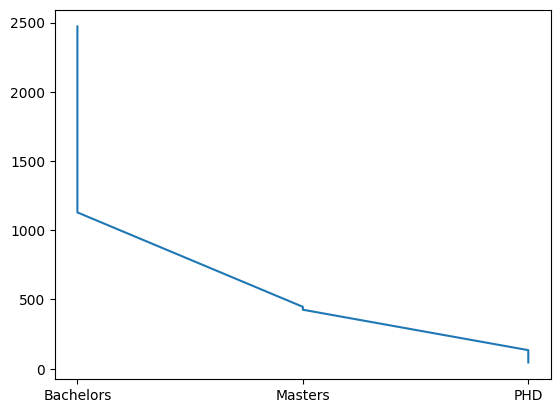

In [10]:
# prompt: create graph of data df using index for date and close on line plot

import matplotlib.pyplot as plt

plt.plot(education['Education'], education['City'], label='LeaveOrNot')

In [523]:
#reference: https://stackoverflow.com/questions/69300562/how-to-define-the-grid-for-using-grid-search-from-scratch-in-python

def makeGrid(pars_dict):
    keys=pars_dict.keys()
    length = len(keys)
    combinations=itertools.product(*pars_dict.values())
    ds=[dict(zip(keys,cc)) for cc in combinations]
    return ds


skf = StratifiedKFold(n_splits=3, shuffle=True)
skf.get_n_splits(X,y)

def search_results(model, grid):
  for x, i in enumerate(grid):
    if model=='XGBClassifier':
      grid_results = np.empty(0)

      for ids, (train_index, test_index) in enumerate(skf.split(X, y)):
        dtrain = xgb.DMatrix(X[train_index], label=y[train_index])
        dtest = xgb.DMatrix(X[test_index], label=y[test_index])
        evallist = [(dtrain, 'train'), (dtest, 'eval')]

        score = xgb.cv(params=i, num_boost_round=200, dtrain=dtrain,  nfold=3, stratified=True, early_stopping_rounds=3, verbose_eval=1)
        index=score.shape[0]-1
        score=1-(score.iloc[index,2])
        grid_results_updated = np.insert(grid_results,[0], score)

        if score< 1:
          best_result = max(grid_results_updated)
          best_model = i

          if score> best_result:
              best_result = best_result
              best_model = i
              print('best result:', i,' ', best_result)
              return best_model
              return max(best_result.mean())

    else:
          grid_results = np.empty(0)
          model.set_params(**i)
          model.fit(X,y)
          score = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
          score=score.mean()
          grid_results=np.ravel(score)
          grid_results_updated = np.insert(grid_results,[0], score)

          return (i, score.mean())
          return grid_results_updated
          print (grid_results_updated)
          if max(grid_results) == score.mean():
              print('best model & params: ', model)
              best_model = model
              return best_model
              return grid_results_updated


In [ ]:
model_selection = ['LogisticRegression', 'RandomForest', 'LinearSVC', 'XGBoost']
#creating different params for different models in loop
model_selection_results = []

for x,i in enumerate(model_selection):
    print(i)
    if i=='LogisticRegression':

      model=LogisticRegression(random_state=45,penalty='elasticnet',class_weight='balanced',solver='saga')
      l1 = arange(0, 1, 0.1)
      C = [  0.001,  0.1,  0.5, 1]
      max_iter = [25,  50, 60, 75, 100]

      hyper_dict = {'C': C, 'l1_ratio': l1, 'max_iter':max_iter}
      grid = makeGrid(hyper_dict)
      model_selection_results.append(search_results(model, grid))

    if i=='RandomForest':

      model = RandomForestClassifier(criterion='gini',class_weight='balanced')
      n_estimators = [50, 100, 200]
      max_features = ['sqrt','log2',20]

      hyper_dict = {'n_estimators': n_estimators, 'max_features': max_features}
      grid = makeGrid(hyper_dict)
      model_selection_results.append(search_results(model, grid))

    if i=='LinearSVC':

      model = LinearSVC(max_iter=100000,tol=0.01,random_state=709,dual=True,class_weight = 'balanced')
      C = [.001,.005,.01,.05,.1,.2,.5,.8,1,3,5,10,20,50,100,500,1000,5000,10000,100000]

      hyper_dict = {'C': C}
      grid = makeGrid(hyper_dict)
      model_selection_results.append(search_results(model, grid))

    if i=='XGBoost':

      objective = ['binary:logistic']
      eval_metric = ['error']
      learning_rates = [0.1, 0.2]
      max_depths = [3, 5,7, 10, 20]
      gamma = [0,1,3]
      lambda_ls = [1,2,3]
      alpha = [0,0.1,1]

      hyper_dict = {'objective': objective, 'eval_metric': eval_metric, 'eta': learning_rates, 'max_depth': max_depths, 'gamma': gamma, 'lambda': lambda_ls, 'alpha': alpha}
      grid = makeGrid(hyper_dict)

      model = 'XGBClassifier'
      model_selection_results.append(search_results(model, grid))


LogisticRegression
RandomForest
LinearSVC
XGBoost
[0]	train-error:0.20245+0.00187	test-error:0.20374+0.00405
[1]	train-error:0.20181+0.00099	test-error:0.20567+0.00164
[2]	train-error:0.20293+0.00254	test-error:0.21051+0.00582
[3]	train-error:0.20181+0.00099	test-error:0.20567+0.00164
[0]	train-error:0.21244+0.00405	test-error:0.22953+0.00759
[1]	train-error:0.21921+0.00851	test-error:0.23630+0.00373
[2]	train-error:0.21277+0.00362	test-error:0.22953+0.00759
[3]	train-error:0.21228+0.00957	test-error:0.23082+0.00121
[0]	train-error:0.20648+0.00172	test-error:0.21857+0.00836
[1]	train-error:0.20616+0.00217	test-error:0.21986+0.01015
[2]	train-error:0.20648+0.00172	test-error:0.21857+0.00836
[3]	train-error:0.20293+0.00060	test-error:0.21631+0.01327
[4]	train-error:0.20471+0.00241	test-error:0.21534+0.01185
[5]	train-error:0.20213+0.00039	test-error:0.21115+0.01089
[6]	train-error:0.20052+0.00139	test-error:0.20632+0.00799
[7]	train-error:0.20035+0.00160	test-error:0.20632+0.00799
[8]	tr

In [ ]:
for i,x in enumerate(model_selection):
  print(model_selection[i], ': ', model_selection_results[i])